In [63]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import trange

In [64]:
import gzip

def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
        return data.astype(np.float32) / 255.0  # Normalize

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
        return labels

# Load from original MNIST files
X_train = load_mnist_images("../Datasets/MNIST/raw/train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("../Datasets/MNIST/raw/train-labels-idx1-ubyte.gz")

X_test = load_mnist_images("../Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("../Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz")

print(f"Loaded X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Loaded X_test: {X_test.shape}, y_train: {y_test.shape}")

Loaded X_train: (60000, 28, 28), y_train: (60000,)
Loaded X_test: (10000, 28, 28), y_train: (10000,)


Loss: 0.10726671776507071: 100%|██████████| 5000/5000 [00:26<00:00, 188.94it/s] 


Text(0.5, 1.0, 'Loss evolution')

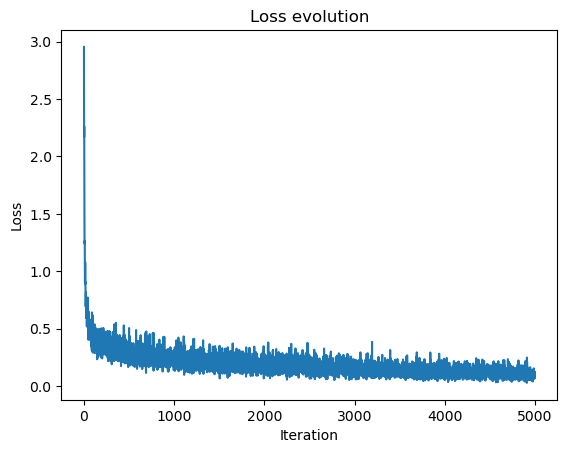

In [69]:
bs = 128
in_dim=784
hid_dim = 256
out_dim=10

max_steps=5000
lr=5e-2
losses=[]

# Weights: 

# Layer 1: (no need for bias because batch norm after)
W1 = np.random.randn(in_dim, hid_dim) / in_dim**0.5
#BatchNorm:
bngain = np.random.randn(1, hid_dim)*0.1 + 1
bnbias = np.random.randn(1, hid_dim)*0.1
# Layer 2:
W2 = np.random.randn(hid_dim, out_dim) / hid_dim**0.5
b2 = np.random.randn(out_dim)

parameters = [W1, W2, b2, bngain, bnbias]

# Batch Norm Running Mean and Var
momentum=0.1
running_mean = np.zeros(hid_dim)
running_var = np.ones(hid_dim)

pbar = trange(max_steps, desc="Training")
for i in pbar:
        idxs = np.random.randint(low=0, high=len(X_train), size=(bs,))
        x, label = np.stack([X_train[i] for i in idxs]), np.array([y_train[i] for i in idxs])

        x = x.reshape(-1, 784)

        # Forward Pass : 
        n = x.shape[0]
        ## Layer 1:
        hprebn = x @ W1
        ### start batchnorm
        bnmean = 1/n * hprebn.sum(0, keepdims=True)
        bndiff = hprebn - bnmean
        bndiff2 = bndiff**2
        bnvar = 1/(n-1) * (bndiff2).sum(0, keepdims=True) # Bessel's correction
        bnvar_inv = (bnvar + 1e-5)**-.5
        bnraw = bndiff*bnvar_inv
        hpreact = bngain*bnraw + bnbias
        ### end batchnorm
        h = np.tanh(hpreact)

        ## Layer 2:
        logits = h @ W2 + b2

        ## Softmax: :
        logits_maxes = logits.max(1, keepdims=True)
        norm_logits = logits - logits_maxes
        counts = np.exp(norm_logits)
        counts_sum = counts.sum(1, keepdims=True)
        counts_sum_inv = counts_sum**-1
        probs = counts*counts_sum_inv

        ## Loss :
        logprobs = np.log(probs)
        loss = - logprobs[range(n), label].mean()
        losses.append(loss.item())

        ## Update Batch Norm running Mean and Var
        running_mean = (1-momentum)*running_mean + momentum*bnmean
        running_var = (1-momentum)*running_var + momentum*bnvar

        # Backprop : 

        dlogprobs = np.zeros_like(logprobs)
        dlogprobs[range(n), label] = -1/n
        dprobs = probs**-1 * dlogprobs
        dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
        dcounts = counts_sum_inv * dprobs
        dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
        dcounts+=dcounts_sum
        dnorm_logits = np.exp(norm_logits) * dcounts
        dlogits_maxes = - dnorm_logits.sum(1, keepdims=True)
        dlogits = dnorm_logits.copy()
        matrix = np.zeros_like(logits)
        indices = logits.argmax(1, keepdims=True)
        matrix[indices]=1
        dlogits += matrix * dlogits_maxes
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1 - h**2)*dh
        dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
        dbnraw = bngain * dhpreact
        dbnbias = dhpreact.sum(0, keepdims=True)
        dbnvar_inv = (dbnraw * bndiff).sum(0, keepdims=True)
        dbndiff = bnvar_inv * dbnraw
        dbnvar = -.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
        dbndiff2 = 1/(n-1) * np.ones_like(bndiff2) * dbnvar 
        dbndiff+=2*bndiff*dbndiff2
        dhprebn = dbndiff.copy()
        dbnmean = - dbndiff.sum(0, keepdims=True)
        dhprebn += 1/n * np.ones_like(hprebn) * dbnmean
        dW1 = x.T @ dhprebn

        grads = [dW1, dW2, db2, dbngain, dbnbias]
        for p, grad in zip(parameters, grads):
            p += - lr*grad
        if i%100==0:
            pbar.set_description(f"Loss: {loss.item()}")
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss evolution')


In [70]:
all_preds = []
all_labels = []

for x, label in zip(X_test, y_test):
    x = x.reshape(-1, 784)

    # Forward Pass : 
    n = x.shape[0]
    ## Layer 1:
    hprebn = x @ W1
    ### start batchnorm
    bndiff = hprebn - running_mean
    bnvar_inv = (running_var)**-.5
    bnraw = bndiff*bnvar_inv
    hpreact = bngain*bnraw + bnbias
    ### end batchnorm
    h = np.tanh(hpreact)

    ## Layer 2:
    logits = h @ W2 + b2

    ## Softmax: :
    logits_maxes = logits.max(1, keepdims=True)
    norm_logits = logits - logits_maxes
    counts = np.exp(norm_logits)
    counts_sum = counts.sum(1, keepdims=True)
    counts_sum_inv = counts_sum**-1
    probs = counts*counts_sum_inv
    pred = np.argmax(probs)
    all_preds.append(pred)
    all_labels.append(label)

all_preds = np.stack(all_preds)
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

Accuracy: 0.9607
